# Modelling the Problem


M DNA strands of length L each are synthesized with each having a random number of copies. The coupling rate determines whether a strand gets attached or not. If its not attached, we move onto the next cycle. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Relationship between the length of the strand synthesized and the coupling rate

Probabilities of strand exisiting vs length of strand given a coupling rate

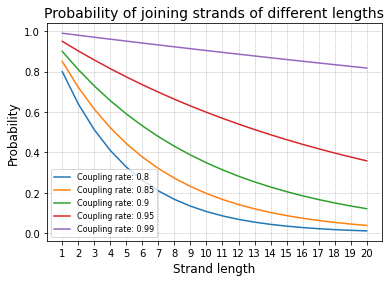

In [11]:
def get_probability_of_strand_joining(coupling_rate, strand_length):
    return coupling_rate**strand_length

def get_probaiblity_of_strand_lengths(coupling_rate, strand_length):
    
    probabilities_strand_lengths = []
    strand_lengths = range(1, strand_length+1)
    for i in strand_lengths:
        probabilities_strand_lengths.append(get_probability_of_strand_joining(coupling_rate, i))

    return probabilities_strand_lengths

def plot_probability_of_strand_lengths(coupling_rate, strand_length, mutliple_plots=False):
    probabilities_strand_lengths = get_probaiblity_of_strand_lengths(coupling_rate, strand_length)
    
    if not mutliple_plots:
        plt.figure(figsize=(10, 6))
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('Strand length', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    

    plt.plot(range(1, strand_length+1), probabilities_strand_lengths, linestyle='-', label='Coupling rate: {}'.format(coupling_rate))
    plt.title('Probability of joining strands of different lengths', fontsize=14)
    plt.legend(fontsize=8)
    plt.xticks(ticks=range(1, strand_length+1), fontsize=10)
    plt.yticks(fontsize=10)

def plot_multiple_coupling_rates_probability_strand_lengths(coupling_rates, strand_length):

    for coupling_rate in coupling_rates:
        plot_probability_of_strand_lengths(coupling_rate, strand_length, mutliple_plots=True)

    plt.show()


coupling_rates = [0.8, 0.85, 0.9, 0.95, 0.99]   
strand_length = 20
plot_multiple_coupling_rates_probability_strand_lengths(coupling_rates, strand_length) 

Distribution of lengths for strand with length L repeated n times; given a coupling rate

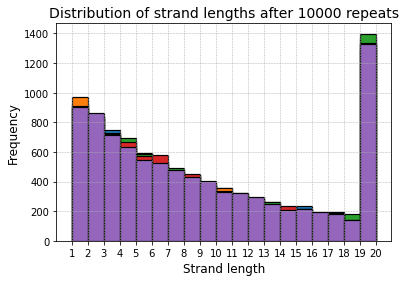

In [31]:

def simulate_synthesis_coupling_single_strand(coupling_rate, strand_length, repeats):

    strand_lengths = []
    for i in range(repeats):
        synthesizing_strand_length = 0
        for j in range(strand_length):
            if np.random.rand() < coupling_rate:
                synthesizing_strand_length += 1
            else:
                break
        strand_lengths.append(synthesizing_strand_length)

    return strand_lengths


def plot_distribution_lengths_single_strand_synthesis(coupling_rate, strand_length, repeats, mutliple_plots=False):
    strand_lengths = simulate_synthesis_coupling_single_strand(coupling_rate, strand_length, repeats)
    plt.hist(strand_lengths, bins=range(1, strand_length), edgecolor='black', linewidth=1.2)
    plt.xlabel('Strand length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of strand lengths after {} repeats'.format(repeats), fontsize=14)
    plt.xticks(ticks=range(1, strand_length+1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if not mutliple_plots:
        plt.show()

coupling_rate = 0.9
strand_length = 20
repeats = 10000

coupling_rates = [0.8, 0.85, 0.9, 0.95, 0.99]
for i in coupling_rates:
    plot_distribution_lengths_single_strand_synthesis(coupling_rate, strand_length, repeats, mutliple_plots=True)

In [30]:
counts

array([ 109,  103,  112,   94,   98,   88,   81,  105,   96,   98,   85,
        103,   82,   79,   73,   93,   93,   83,   89,   75, 8161],
      dtype=int64)

In [28]:
strand_lengths

NameError: name 'strand_lengths' is not defined

## First Naive Model

So strand of Length n, repeated k times with a coupling rate alpha.
Simulate sequencing errors as independent events per base with probabilities based on IDS errors. 
Investigate the effect of coupling rate on percentage recovery - Do deletion errors at synthesis completely ruin consensus decoding?


In [59]:
import numpy as np

In [60]:

bases = ['A', 'T', 'C', 'G']

class NaiveSynthesisModel:
    """
    Single strand synthesis model -
    n length strand, k repeats, with coupling rate alpha per base
    Option for capping or not, to end synthesis if a base is not added
    """

    def __init__(self, coupling_rate, strand_length, repeats,
                  capping=True):
        self.coupling_rate = coupling_rate
        self.strand_length = strand_length
        self.repeats = repeats
        self.strand = "".join(np.random.choice(bases, strand_length))
        self.capping = capping

    def simulate_synthesis(self):

        self.synthesized_strands = []
        for i in range(self.repeats):
            synthesizing_strand = ""
            for j in range(self.strand_length):
                if np.random.rand() < self.coupling_rate:
                    synthesizing_strand += self.strand[j]
                else:
                    if self.capping:
                        break
                    continue
            self.synthesized_strands.append(synthesizing_strand)

        return self.synthesized_strands

In [61]:
class NaiveSequencingModel:
    """
    Single strand sequencing model -
    Independent base IDS errors
    """

    def __init__(self, insertion_probability=0.015,
                  deletion_probability=0.055, subsitution_probability=0.075,
                    strand_length=20):
        self.insertion_probability = insertion_probability
        self.deletion_probability = deletion_probability
        self.subsitution_probability = subsitution_probability
        self.strand_length = strand_length

    def simulate_sequencing(self, strand):
        sequenced_strand = ""
        for i in range(len(strand)):
            
            # If there is an insertion, add a random base
            if np.random.rand() < self.insertion_probability:
                sequenced_strand += np.random.choice(bases)
            
            # If there is a deletion, skip the base
            if np.random.rand() < self.deletion_probability:
                continue

            # If there is a subsitution, replace the base
            if np.random.rand() < self.subsitution_probability:
                sequenced_strand += np.random.choice(bases)
                continue

            sequenced_strand += strand[i]

        return sequenced_strand
    
    def simulate_full_sequencing(self, strands):

        sequenced_strands = []
        for strand in strands:
            sequenced_strands.append(self.simulate_sequencing(strand))
        
        return sequenced_strands
    
        
    def consensus_decoding(self, sequenced_strands):
        """
        Sequenced copies of the same strand, using majority voting to decode
        """
        A_votes = np.zeros(self.strand_length)
        T_votes = np.zeros(self.strand_length)
        C_votes = np.zeros(self.strand_length)
        G_votes = np.zeros(self.strand_length)

        for i in range(self.strand_length):
            for j in sequenced_strands:
                if i >= len(j):
                    continue
                if j[i] == 'A':
                    A_votes[i] += 1
                elif j[i] == 'T':
                    T_votes[i] += 1
                elif j[i] == 'C':
                    C_votes[i] += 1
                else:
                    G_votes[i] += 1
        
        consensus_strand = ""
        bases = ['A', 'T', 'C', 'G']
        for i in range(self.strand_length):
            votes = [A_votes[i], T_votes[i], C_votes[i], G_votes[i]]
            consensus_strand += bases[np.argmax(votes)]

        return consensus_strand



In [62]:
class NaiveDNAStorageModel:

    def __init__(self, coupling_rate, strand_length, repeats,
                  insertion_probatility=0.015, deletion_probability=0.055, subsitution_probability=0.075,
                  capping=True):
        self.synthesis_model = NaiveSynthesisModel(coupling_rate, strand_length, repeats, capping)
        self.strand = self.synthesis_model.strand
        self.sequencing_model = NaiveSequencingModel(insertion_probatility, deletion_probability, subsitution_probability, strand_length)
        self.strand_length = strand_length

    def simulate_storage(self):
        synthesized_strands = self.synthesis_model.simulate_synthesis()
        sequenced_strands = self.sequencing_model.simulate_full_sequencing(synthesized_strands)
        consensus_strand = self.sequencing_model.consensus_decoding(sequenced_strands)

        return consensus_strand

In [80]:
model = NaiveDNAStorageModel(0.7, 20, 1000, capping=False)

In [83]:
model.simulate_storage()

'GTGTTAAAACCCCCCCCCCC'

In [84]:
model.strand

'GTGGTTAGATCAACACCTTC'

In [90]:
def recovery_percentage_coupling_rate(coupling_rates, strand_length, repeats, simulations, capping=True):
    recovery_percentages = []
    for coupling_rate in coupling_rates:
        local_recovery_percentages = []
        for i in range(simulations):
            model = NaiveDNAStorageModel(coupling_rate, strand_length, repeats, capping=capping)
            consensus_strand = model.simulate_storage()
            recovery_percentage = sum([1 for i in range(len(consensus_strand)) if consensus_strand[i] == model.strand[i]])/len(consensus_strand)
            local_recovery_percentages.append(recovery_percentage)
        
        recovery_percentages.append(np.mean(local_recovery_percentages))

    return recovery_percentages

In [91]:
recovery_percentage_coupling_rate([0.7, 0.8, 0.9, 0.95, 0.99], 20, 1000, 100, capping=False)

[0.39549999999999996, 0.4835000000000001, 0.617, 0.7304999999999999, 0.872]

In [92]:
recovery_percentage_coupling_rate([0.7, 0.8, 0.9, 0.95, 0.99], 20, 1000, 100, capping=True)

[0.8035000000000001, 0.9395, 0.954, 0.9449999999999998, 0.9414999999999999]

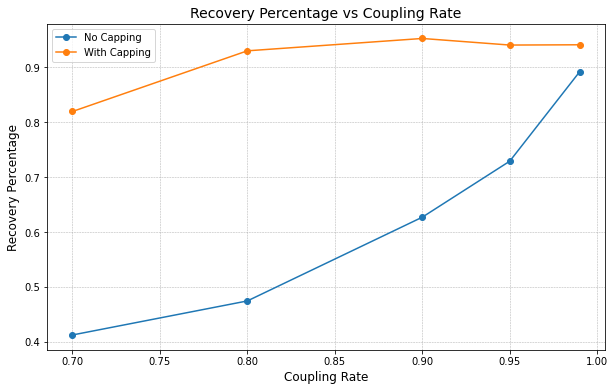

In [93]:
import matplotlib.pyplot as plt

# Assuming recovery percentages for different coupling rates are already calculated
coupling_rates = [0.7, 0.8, 0.9, 0.95, 0.99]
recovery_percentages_no_capping = recovery_percentage_coupling_rate(coupling_rates, 20, 1000, 100, capping=False)
recovery_percentages_with_capping = recovery_percentage_coupling_rate(coupling_rates, 20, 1000, 100, capping=True)

plt.figure(figsize=(10, 6))
plt.plot(coupling_rates, recovery_percentages_no_capping, marker='o', linestyle='-', label='No Capping')
plt.plot(coupling_rates, recovery_percentages_with_capping, marker='o', linestyle='-', label='With Capping')
plt.xlabel('Coupling Rate', fontsize=12)
plt.ylabel('Recovery Percentage', fontsize=12)
plt.title('Recovery Percentage vs Coupling Rate', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Testing with a longer strand length

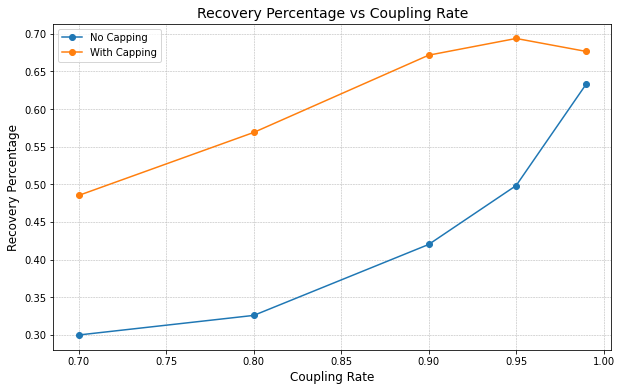

In [94]:
import matplotlib.pyplot as plt

# Assuming recovery percentages for different coupling rates are already calculated
coupling_rates = [0.7, 0.8, 0.9, 0.95, 0.99]
recovery_percentages_no_capping = recovery_percentage_coupling_rate(coupling_rates, 50, 1000, 100, capping=False)
recovery_percentages_with_capping = recovery_percentage_coupling_rate(coupling_rates, 50, 1000, 100, capping=True)

plt.figure(figsize=(10, 6))
plt.plot(coupling_rates, recovery_percentages_no_capping, marker='o', linestyle='-', label='No Capping')
plt.plot(coupling_rates, recovery_percentages_with_capping, marker='o', linestyle='-', label='With Capping')
plt.xlabel('Coupling Rate', fontsize=12)
plt.ylabel('Recovery Percentage', fontsize=12)
plt.title('Recovery Percentage vs Coupling Rate', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

I mean it makes sense that capping is better for consensus decoding since overall error reduces by a large margin and we avoid any deletion errors at synthesis
But for error correcting coding, it may be more beneficial

### Likelihood function

In [ ]:


def get_base_likelihoods(strand_length, A_votes, T_votes, C_votes, G_votes):
    """Given the votes per position of the strand, get the symbol likelihood array"""

    likelihoods = []
    for i in range(strand_length):
        votes = [A_votes[i], T_votes[i], C_votes[i], G_votes[i]]
        likelihoods.append(votes/np.sum(votes))

    return likelihoods



1.0
